In [42]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [43]:
train_df = pd.read_csv("/Users/hakanzip/Desktop/veri-bilimi-10-proje/08_MNIST/mnist_train.csv")
test_df  = pd.read_csv("/Users/hakanzip/Desktop/veri-bilimi-10-proje/08_MNIST/mnist_test.csv")

In [44]:
# Eğitim verisinin ilk 5 satırı
train_df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


In [46]:
train_df.isnull().sum().sum()

np.int64(0)

In [47]:
sabit_sutunlar = [col for col in train_df.columns if train_df[col].nunique() == 1]
sabit_sutunlar

['1x1',
 '1x2',
 '1x3',
 '1x4',
 '1x5',
 '1x6',
 '1x7',
 '1x8',
 '1x9',
 '1x10',
 '1x11',
 '1x12',
 '1x17',
 '1x18',
 '1x19',
 '1x20',
 '1x21',
 '1x22',
 '1x23',
 '1x24',
 '1x25',
 '1x26',
 '1x27',
 '1x28',
 '2x1',
 '2x2',
 '2x3',
 '2x4',
 '2x25',
 '2x26',
 '2x27',
 '2x28',
 '3x1',
 '3x2',
 '3x27',
 '3x28',
 '4x1',
 '4x2',
 '4x28',
 '5x1',
 '6x1',
 '6x2',
 '7x1',
 '18x1',
 '21x1',
 '24x1',
 '24x2',
 '24x28',
 '25x1',
 '25x2',
 '25x28',
 '26x1',
 '26x2',
 '26x28',
 '27x1',
 '27x2',
 '27x3',
 '27x27',
 '27x28',
 '28x1',
 '28x2',
 '28x3',
 '28x4',
 '28x25',
 '28x26',
 '28x27',
 '28x28']

In [48]:
train_df.duplicated().sum()

np.int64(0)

Aynı veriyi taşıyan satırları sildik.

In [49]:
train_df.dtypes.value_counts() #veri türü

int64    785
Name: count, dtype: int64

In [50]:
pixel_columns = train_df.columns[1:]  # 'label' hariç
min_pixel = train_df[pixel_columns].min().min()
max_pixel = train_df[pixel_columns].max().max()
print(f"Piksel aralığı: min = {min_pixel}, max = {max_pixel}")

Piksel aralığı: min = 0, max = 255


FEATURE ENGINEERING

In [51]:
train_df['pixel_sum'] = train_df.iloc[:, 1:].sum(axis=1)

Pixelin toplam parlaklığı ayırt edici bir özellik olabilir.

In [52]:
left_half = train_df.iloc[:, 1:1 + 392]
train_df['left_heavy'] = left_half.sum(axis=1)

Sol taraftaki pixeller daha yoğunsa bu 1'i gösteriyor olabilir

In [53]:
train_df['nonzero_count'] = (train_df.iloc[:, 1:] > 0).sum(axis=1)

Yazı alanı yoğunluğu hakkında bilgi verir.

In [54]:
train_df['pixel_std'] = train_df.iloc[:, 1:].std(axis=1)

Görsel içindeki piksellerin ne kadar değişken olduğunu ölçer. 

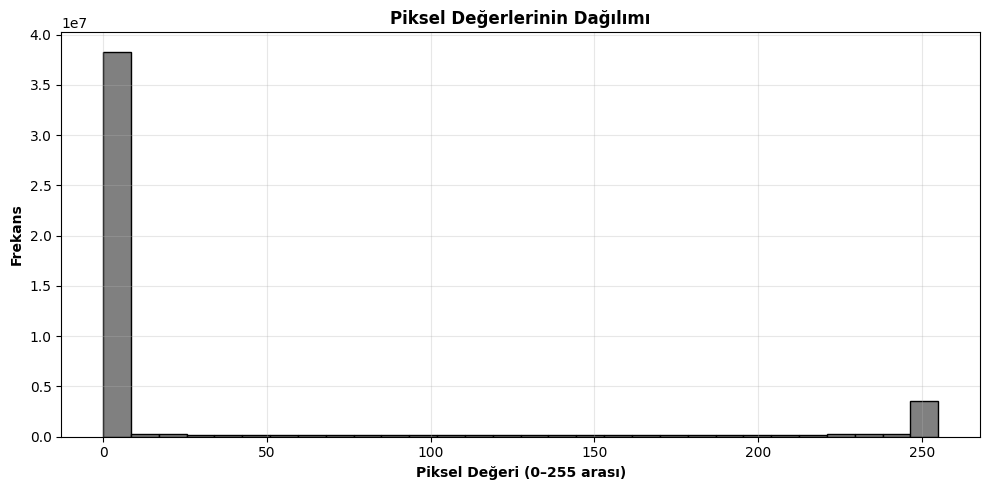

In [55]:
# İlk sütun 'label', son 4 sütun feature engineering sütunlarıysa 1:785 arası pikselleri seçiyoruz
# Alternatif olarak sadece 28x28 = 784 sütunluk kısmı al
pixel_columns = train_df.columns[1:785]  # İlk 784 piksel sütunu (label hariç, yeni özellikler hariç)
pixel_values = train_df[pixel_columns].values.flatten()

# Histogram
plt.figure(figsize=(10, 5))
plt.hist(pixel_values, bins=30, color="gray", edgecolor="black")
plt.title("Piksel Değerlerinin Dağılımı", fontweight="bold")
plt.xlabel("Piksel Değeri (0–255 arası)", fontweight="bold")
plt.ylabel("Frekans", fontweight="bold")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Bu grafik, tüm görsellerdeki piksellerin hangi değerde kaç kez geçtiğini gösterir. 
0 değeri siyah, 255 değeri beyazı temsil eder. Hangi tonların baskın olduğunu anlamamızı sağlar. 

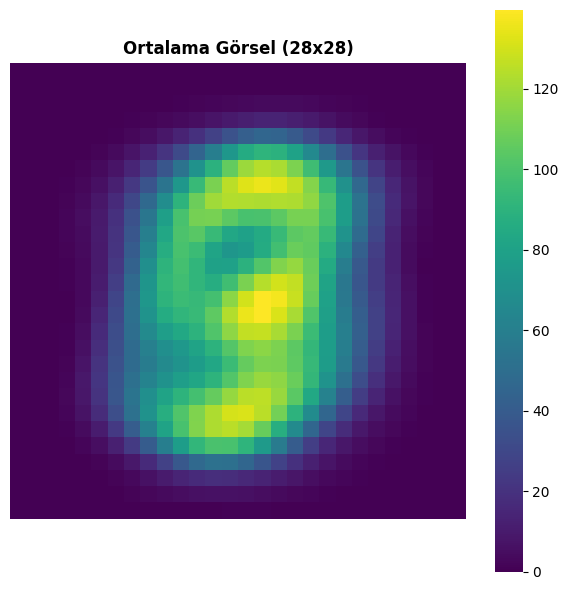

In [56]:
pixel_columns = train_df.columns[1:785]
average_pixels = train_df[pixel_columns].mean().values.reshape(28, 28)
plt.figure(figsize=(6, 6))
sns.heatmap(average_pixels, cmap="viridis", cbar=True, square=True)
plt.title("Ortalama Görsel (28x28)", fontweight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()

Bu görsel, eğitim veri setindeki tüm rakamların ortalamasının 28x28 boyutlu ısı haritasıdır. 
Her pikseldeki sayıların ortalaması hesaplanmış ve bu ortalama değerler görselleştirilmiştir. Tüm piksellerin ortalaması 3'e benziyor diyebiliriz ama bu önemsizdir.

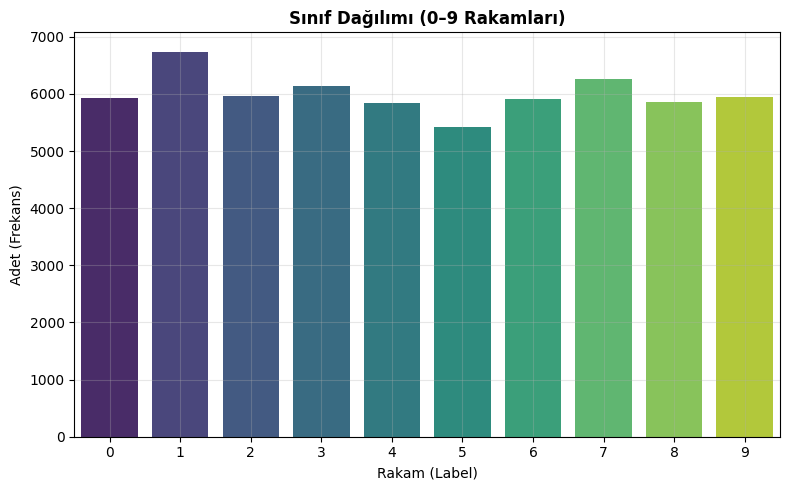

In [57]:
# Sınıf etiketlerinin sayısını barplot ile görselleştiriyoruz
plt.figure(figsize=(8, 5))
sns.countplot(x=train_df['label'], palette='viridis')
plt.title("Sınıf Dağılımı (0–9 Rakamları)", fontweight="bold")
plt.xlabel("Rakam (Label)")
plt.ylabel("Adet (Frekans)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Bu grafik, veri setinde her rakamdan (0–9) kaç tane olduğunu gösterir. Modelin eğitileceği sınıfların dengeli olup olmadığını anlamamıza yardımcı olur. Model gayet dengeli görünüyor.

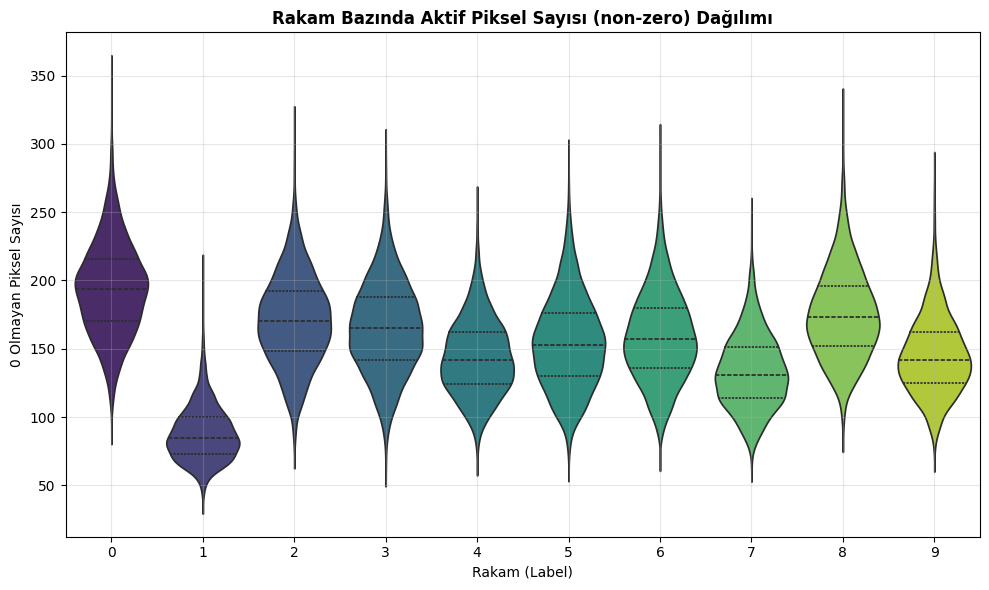

In [58]:
plt.figure(figsize=(10, 6))
sns.violinplot(
    x=train_df['label'],
    y=train_df['nonzero_count'],
    palette='viridis',
    inner='quartile'
)
plt.title("Rakam Bazında Aktif Piksel Sayısı (non-zero) Dağılımı", fontweight="bold")
plt.xlabel("Rakam (Label)")
plt.ylabel("0 Olmayan Piksel Sayısı")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Her rakamın görselde ne kadar alan kapladığını analiz eder. 0 olmayan piksel sayısı ne kadar fazlaysa, o kadar çok çizilmiş demektir. Violin plot, her sınıfın dağılımını ve iç yoğunluklarını detaylı biçimde gösterir.

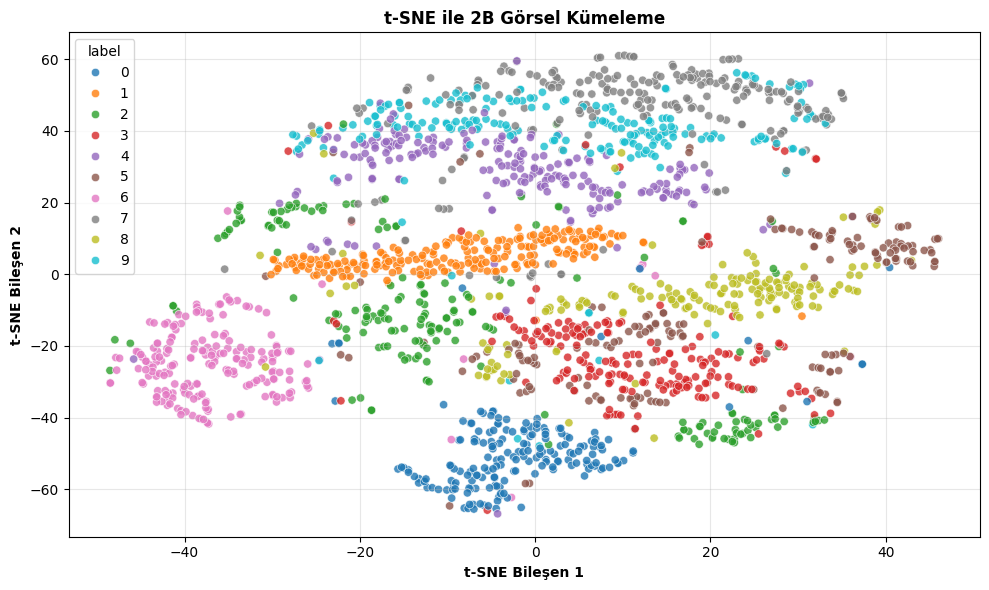

In [59]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
X_pixels = train_df.iloc[:, 1:785]
y_labels = train_df['label']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pixels)

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled[:2000])

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=y_labels[:2000],
    palette='tab10',
    legend='full',
    alpha=0.8
)
plt.title("t-SNE ile 2B Görsel Kümeleme", fontweight="bold")
plt.xlabel("t-SNE Bileşen 1", fontweight="bold")
plt.ylabel("t-SNE Bileşen 2", fontweight="bold")
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()

t-SNE algoritması, yüksek boyutlu verileri 2 boyuta indirger ve benzer örnekleri birbirine yakın yerleştirir. 
Bu grafik, rakamların görsel benzerliğine göre nasıl kümelendiğini gösterir. Aynı rakamlar aynı yerde gruplaşmış ama bazı kısımlar karışmış durumda.

In [60]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


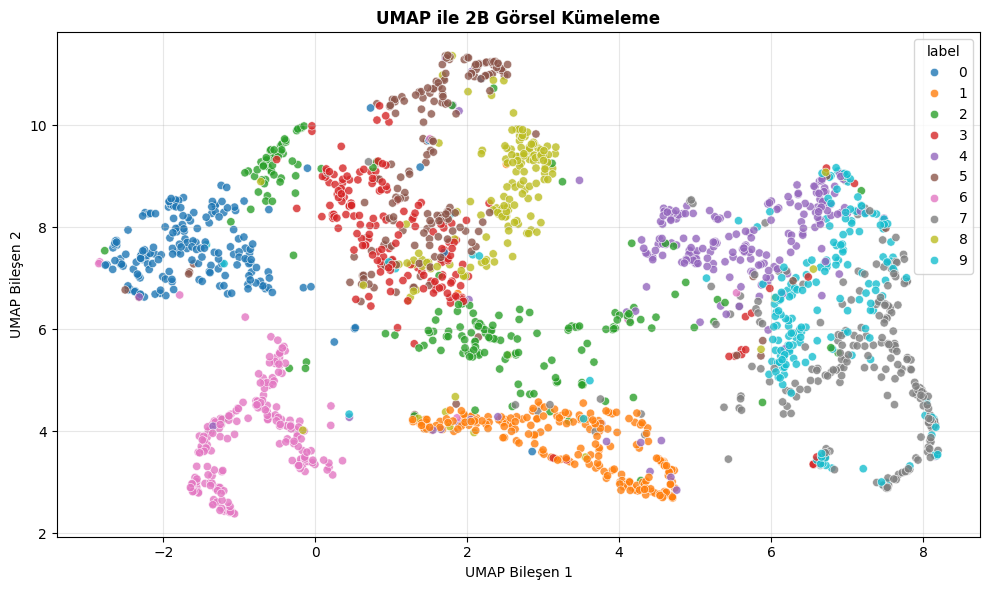

In [61]:
import umap
from sklearn.preprocessing import StandardScaler

X_pixels = train_df.iloc[:, 1:785]
y_labels = train_df['label']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pixels)

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_scaled[:2000])

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    hue=y_labels[:2000],
    palette='tab10',
    legend='full',
    alpha=0.8
)
plt.title("UMAP ile 2B Görsel Kümeleme", fontweight="bold")
plt.xlabel("UMAP Bileşen 1")
plt.ylabel("UMAP Bileşen 2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

UMAP, yüksek boyutlu verileri 2 boyuta indirgerken global ve lokal yapıyı birlikte korur. t-SNE’ye benzer ama daha hızlı çalışır ama bende daha hızlı çalışmadı. t-SNE’ye göre daha iyi kümelenmiş gibi.

In [62]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import plotly.express as px

X_pixels = train_df.iloc[:, 1:785]
y_labels = train_df['label']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pixels)

tsne_3d = TSNE(n_components=3, perplexity=30, random_state=42, n_iter=1000)
X_tsne_3d = tsne_3d.fit_transform(X_scaled[:2000])
labels_subset = y_labels[:2000]

fig = px.scatter_3d(
    x=X_tsne_3d[:, 0],
    y=X_tsne_3d[:, 1],
    z=X_tsne_3d[:, 2],
    color=labels_subset.astype(str),
    title="t-SNE ile 3D Küme Görselleştirme",
    labels={'color': 'Label'}
)
fig.update_traces(marker=dict(size=4))
fig.show()

Bu görsel, t-SNE algoritmasıyla yüksek boyutlu veriyi 3 boyuta indirerek sınıfların uzayda nasıl ayrıştığını gösterir. 
Her bir nokta bir rakam görselini, renkler ise hangi rakama ait olduğunu ifade eder. 
2D'ye göre daha sezgisel, daha detaylı ayrım analizi yapılabilir. 2 rakamı dışında karışan bir veri yok.

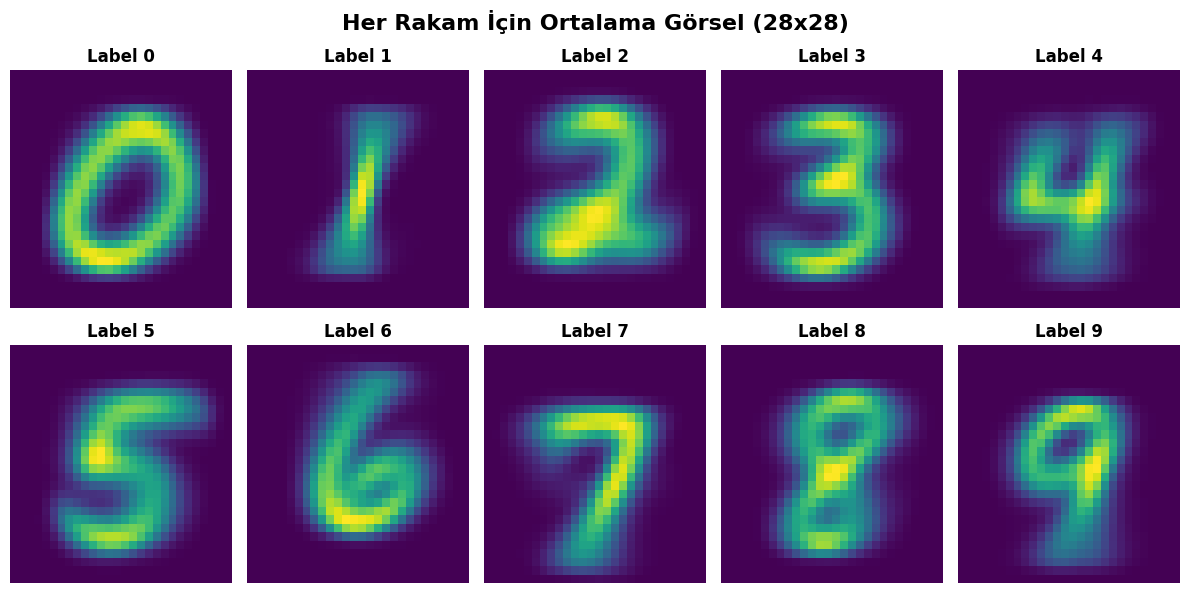

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("Her Rakam İçin Ortalama Görsel (28x28)", fontweight="bold", fontsize=16)
for i in range(10):
    ax = axes[i // 5, i % 5]
    
    digit_data = train_df[train_df['label'] == i].iloc[:, 1:785]
    avg_image = digit_data.mean().values.reshape(28, 28)
    sns.heatmap(
        avg_image,
        ax=ax,
        cmap='viridis',
        cbar=False,
        xticklabels=False,
        yticklabels=False
    )
    ax.set_title(f"Label {i}", fontweight="bold")

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Bu görselde 0’dan 9’a kadar her rakam sınıfı için ortalama görseller gösterilmektedir. Her sınıfa ait tüm görseller üst üste bindirilerek ortalaması alınmıştır. Rakamların genel yazım şekilleri ve merkezde yoğunlaşıp yoğunlaşmadıkları bu şekilde sezgisel olarak anlaşılır.

MODELLEME

In [67]:
X = train_df.iloc[:, 1:785]
y = train_df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Veri eğitim ve test olarak ayrıldı, ardından ölçeklendi çünkü bazı modeller buna duyarlıdır.  

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

rf_pred = rf_model.predict(X_test_scaled)

print("Random Forest Accuracy:", round(accuracy_score(y_test, rf_pred), 4))
print("\nClassification Report:\n")
print(classification_report(y_test, rf_pred))

Random Forest Accuracy: 0.9663

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1185
           1       0.97      0.98      0.98      1348
           2       0.96      0.97      0.96      1192
           3       0.96      0.94      0.95      1226
           4       0.97      0.97      0.97      1168
           5       0.96      0.96      0.96      1084
           6       0.98      0.98      0.98      1184
           7       0.98      0.96      0.97      1253
           8       0.95      0.95      0.95      1170
           9       0.95      0.95      0.95      1190

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



Random Forest modeli kuruldu ve test verisinde %96.63 doğruluk elde edildi, bu çok yüksek ve başarılı bir sonuçtur.

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(128,), activation='relu',
                          solver='adam', max_iter=30, random_state=42)
mlp_model.fit(X_train_scaled, y_train)
mlp_pred = mlp_model.predict(X_test_scaled)
print("MLP Classifier Accuracy:", round(accuracy_score(y_test, mlp_pred), 4))
print("\nClassification Report:\n")
print(classification_report(y_test, mlp_pred))

MLP Classifier Accuracy: 0.9754

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1185
           1       0.98      0.99      0.99      1348
           2       0.96      0.97      0.97      1192
           3       0.98      0.96      0.97      1226
           4       0.97      0.98      0.98      1168
           5       0.98      0.98      0.98      1084
           6       0.99      0.98      0.98      1184
           7       0.98      0.97      0.98      1253
           8       0.96      0.96      0.96      1170
           9       0.97      0.96      0.97      1190

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



MLP modeli bir yapay sinir ağıdır, eğitildi ve test setinde %97.54 doğruluk sağladı. Model neredeyse tüm rakamları yüksek başarıyla ayırabildi, genel performans çok güçlü.

In [71]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [72]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

xgb_pred = xgb_model.predict(X_test_scaled)

print("XGBoost Accuracy:", round(accuracy_score(y_test, xgb_pred), 4))
print("\nClassification Report:\n")
print(classification_report(y_test, xgb_pred))

XGBoost Accuracy: 0.9772

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1185
           1       0.98      0.99      0.99      1348
           2       0.97      0.98      0.97      1192
           3       0.98      0.96      0.97      1226
           4       0.98      0.98      0.98      1168
           5       0.97      0.98      0.97      1084
           6       0.99      0.98      0.98      1184
           7       0.99      0.97      0.98      1253
           8       0.97      0.97      0.97      1170
           9       0.96      0.97      0.97      1190

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



XGBoost modeli kuruldu ve test setinde %97.72 doğruluk verdi, bu 3 model arasında en iyi sonuçtu. Model hem güçlü hem kararlı, rakamları ayırmada çok başarılı çalıştı. Modellerin babası gibi XGBoost.

In [79]:
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_mlp = mlp_model.predict(X_test_scaled)
y_pred_xgb = xgb_model.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
models = {
    "Random Forest": (rf_model, y_pred_rf),
    "MLP Classifier": (mlp_model, y_pred_mlp),
    "XGBoost": (xgb_model, y_pred_xgb)}
results = []
for name, (model, preds) in models.items():
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted') 
    results.append((name, acc, f1))
perf_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score"])
display(perf_df)

,Model,Accuracy,F1 Score
0,Random Forest,0.966250,0.966225
1,MLP Classifier,0.975417,0.975405
2,XGBoost,0.977167,0.977168


Bu tablo hangi modelin daha iyi tahmin yaptığını karşılaştırmalı olarak gösterir. XGBoost babadır.